# Um modelo bayesiano hierárquico do Campeonato Brasileiro Serie A

No outono passado, eu estava ouvindo um episódio do podcast BS Report no qual Bill Simmons e Primo Sal estavam discutindo a força de diferentes equipes da NFL.   

Foi no início da temporada - semana 3 ou 4, talvez - e Bill enfatizou (estou parafraseando aqui) que sua estimativa da força de uma equipe depende da estimativa de todas as outras.  

As conclusões que você tira do time X que vence o time Y dependem da força do time Y, o que, por sua vez, depende das conclusões que você tira dos outros jogos do time Y, que por sua vez dependem da força dos oponentes do Y, etc.

Ocorreu-me que esse problema é perfeito para um modelo bayesiano.   

Queremos inferir os parâmetros latentes (força de todas as equipes) que estão gerando os dados que observamos (as pontuações).   
Além disso, sabemos que as pontuações são uma medida ruidosa da força da equipe; portanto, idealmente, queremos um modelo que facilite a quantificação de nossa incerteza sobre as forças subjacentes.  

Então, pesquisei 'futebol bayesiano' e encontrei este artigo, chamado 'modelo hierárquico bayesiano para a previsão de resultados do futebol'.  

Os autores (Gianluca Baio e Marta A. Blangiardo) são italianos, porém, o 'futebol' aqui é o futebol.

Neste post, reproduzirei o primeiro modelo descrito no artigo usando pymc. Enquanto eles usaram a Seria A em seu trabalho, vou usar a Premier League 2013-2014.

# Obtendo e limpando os dados

Eu peguei os dados da wikipedia. Copiei a 'Tabela de resultados' e a salvei como um arquivo de texto.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import math
import warnings
warnings.filterwarnings('ignore')
import os
from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pymc # I know folks are switching to "as pm" but I'm just not there yet

In [3]:
DATA_DIR = os.path.join(os.getcwd(), 'data/')
CHART_DIR = os.path.join(os.getcwd(), 'charts/')

In [4]:
data_file = DATA_DIR + 'Brasileiro_Serie_A_2019.txt'
df = pd.read_csv(data_file, sep='\t', index_col=0,)
df.head()

,CAP,CAM,AVA,BAH,BOT,CEA,CHA,COR,CRU,CSA,FLA,FLU,FOR,GOI,GRE,INT,PAL,SAN,SPA,VAS
Home \ Away,,,,,,,,,,,,,,,,,,,,
Athletico Paranaense,-,1-0,0-1,1-0,1-0,1-0,1-1,0-2,0-0,1-0,0-2,3-0,4-1,4-1,2-0,1-0,1-1,1-0,0-1,4-1
Atlético Mineiro,0-1,-,2-1,0-1,2-0,2-1,0-2,2-1,2-0,4-0,2-1,2-1,2-2,2-0,1-4,1-3,0-2,2-0,1-1,1-2
Avaí,0-0,1-0,-,0-2,0-2,1-2,0-1,1-1,2-2,0-0,0-3,1-1,1-3,0-0,1-1,0-2,1-2,1-2,0-0,0-0
Bahia,1-2,1-1,1-0,-,2-0,1-2,1-1,3-2,0-0,1-0,3-0,3-2,1-1,1-1,1-0,2-3,1-1,0-1,0-0,1-1
Botafogo,2-1,2-1,2-0,3-2,-,1-1,0-0,1-0,0-2,2-1,0-1,0-1,1-0,3-1,0-1,0-1,0-1,0-1,1-2,1-0


Claramente, precisamos fazer alguma coisa aqui. Vamos transformar isso em um quadro de dados longo e dividir a pontuação em duas colunas numéricas.

In [5]:
df.index = df.columns
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        score = df.loc[i, c]
        score = [int(row) for row in score.split('-')]
        rows.append([i, c, score[0], score[1]])
df = pd.DataFrame(rows)
df.columns = ['home', 'away', 'home_score', 'away_score']
df.head()

,home,away,home_score,away_score
0,CAP,CAM,1,0
1,CAP,AVA,0,1
2,CAP,BAH,1,0
3,CAP,BOT,1,0
4,CAP,CEA,1,0


Muito melhor, mas ainda não feito. Precisamos de uma maneira fácil de nos referir às equipes. Vamos criar uma tabela de pesquisa, que mapeia o nome da equipe para um número inteiro exclusivo i.

In [6]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,CAP,0
1,CAM,1
2,AVA,2
3,BAH,3
4,BOT,4


Agora, podemos mesclar isso em nosso dataframe principal para criar as colunas i_casa e i_fora.

In [7]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,CAP,CAM,1,0,0,1
1,CAP,AVA,0,1,0,2
2,CAP,BAH,1,0,0,3
3,CAP,BOT,1,0,0,4
4,CAP,CEA,1,0,0,5


Agora, vamos extrair os dados em matrizes, para que o pymc possa trabalhar com eles.  

Observe que cada uma das matrizes (`gols_observados_casa`, `gols_observados_visita`, `time_casa', ´time_visita`) tem o mesmo comprimento e que a i-ésima entrada de cada uma refere-se ao mesmo jogo.

Este próximo passo é desnecessário, mas eu gosto de fazê-lo de qualquer maneira - crie alguns valores iniciais decentes para os parâmetros att e def. A transformação do log fará sentido em breve.

In [8]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [9]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

# O Modelo

No primeiro modelo do artigo, eles modelam as contagens de gols observadas como:
\begin{equation*}
y_{gj}|\theta_{gj} = Poisson(\theta_{gj})
\end{equation*}

onde $\theta_{gj} = (\theta_{g1}, \theta_{g2})$ representa a intensidade de pontuação no g-ésimo jogo para o time que joga em casa (j = 1) e viista (j = 2), respectivamente.
É usado um modelo log-linear para $\theta$:
\begin{equation*}
log\theta_{g1} = casa + att_{h(g)} + def_{a(g)}
\end{equation*}
\begin{equation*}
log\theta_{g2} = att_{a(g)} + def_{h(g)} 
\end{equation*}

Observe que eles estão dividindo a força da equipe em força de ataque e defesa. 
Um parâmetro de defesa negativo irá minar o mojo do parâmetro de ataque da equipe adversária.

A varáivel `casa` representa a vantagem do time da casa e, neste modelo, assume-se constante entre as equipes.   

Os parâmetros a priori no início e na intercepto são simples (lembre-se de que no pymc, os normais são especificados como (média, precisão):
\begin{equation*}
home∼Normal(0, 0.0001)
\end{equation*}
\begin{equation*}
intercepto ∼ Normal(0, .0001)
\end{equation*}

Os efeitos específicos da equipe são modelados como permutáveis:
\begin{equation*}
att_t∼Normal(\mu_{att},\tau_{att})
\end{equation*}
\begin{equation*}
def_t∼Normal (\mu_{def},\tau_{def}
\end{equation*}

Para garantir a identificabilidade, eles impõem uma restrição de soma a zero nos parâmetros de ataque e defesa. Eles também tentaram uma restrição de canto (fixando os parâmetros de uma equipe em 0,0), mas descobriram que a interpretação é mais fácil no caso de soma zero, porque não é relativa à equipe 0,0.

\begin{equation*}
\sum_{t=1}^T att_t = 0
\end{equation*}
\begin{equation*}
\sum_{t=1}^T def_t = 0
\end{equation*}


=t = 1Tattt = 0
=\t = 1Tdeft = 0
Os hiperpriores dos parâmetros de ataque e defesa também são simples:
\begin{equation*}
\mu_{att}∼Normal(0, 0,0001)
\end{equation*}
\begin{equation*}
\mu_{def}∼Normal (0, .0001)
\end{equation*}
\begin{equation*}
\tau_{att}∼Gamma (.1, .1)
\end{equation*}
\begin{equation*}
\tau_{def}∼Gamma (.1, .1)
\end{equation*}

In [10]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 58.2 sec

Diagnóstico
Vamos ver se / como o modelo convergiu. O parâmetro home parece bom e indica que a vantagem do campo home é de $e^.5-e^.3 =.29$ gols por jogo no intercepto

Generating histogram of home


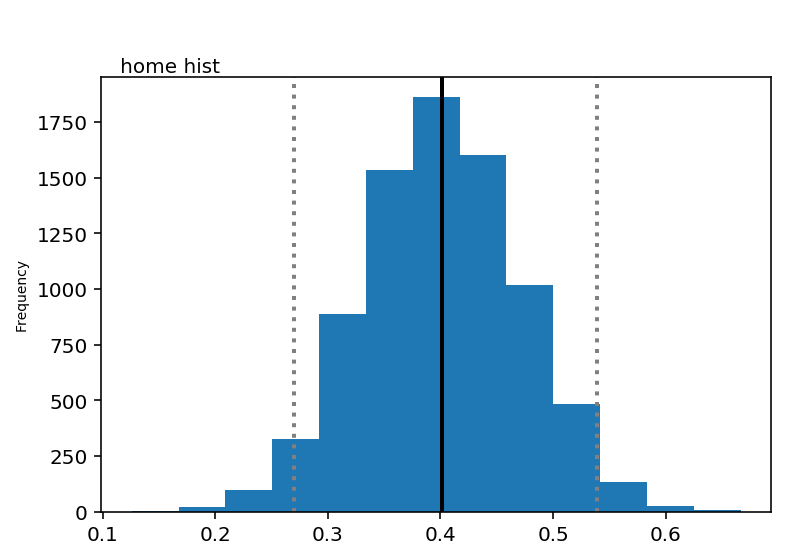

In [11]:
pymc.Matplot.histogram(home)

In [12]:
home.summary()


home:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.401            0.07             0.001              [0.27  0.539]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.267            0.353           0.401          0.448         0.537
	


Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


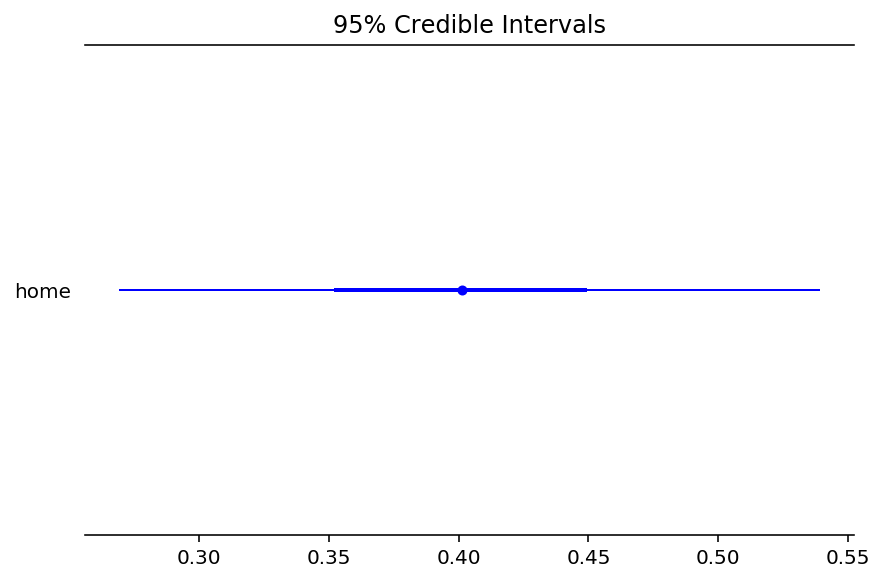

In [13]:
pymc.Matplot.summary_plot(home)

Generating histogram of intercept


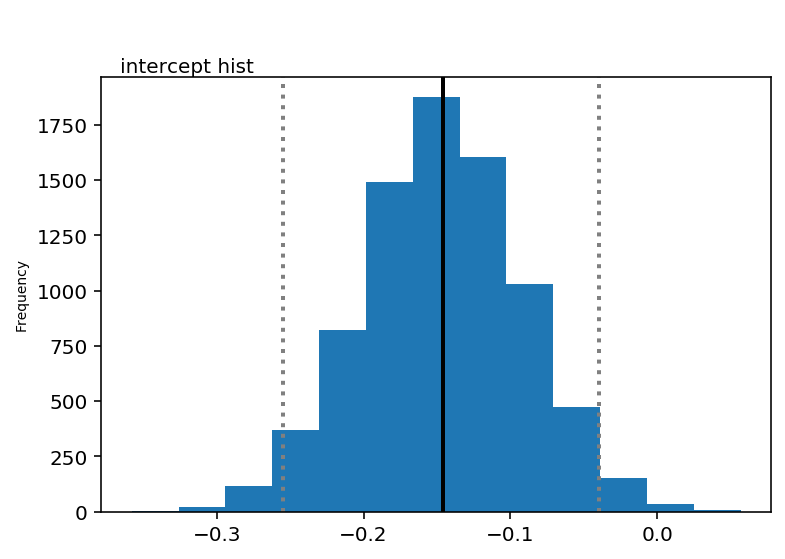

In [14]:
pymc.Matplot.histogram(intercept)

In [15]:
intercept.summary()


intercept:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.146           0.055            0.001            [-0.255 -0.04 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.255           -0.183          -0.146         -0.109        -0.04
	


Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


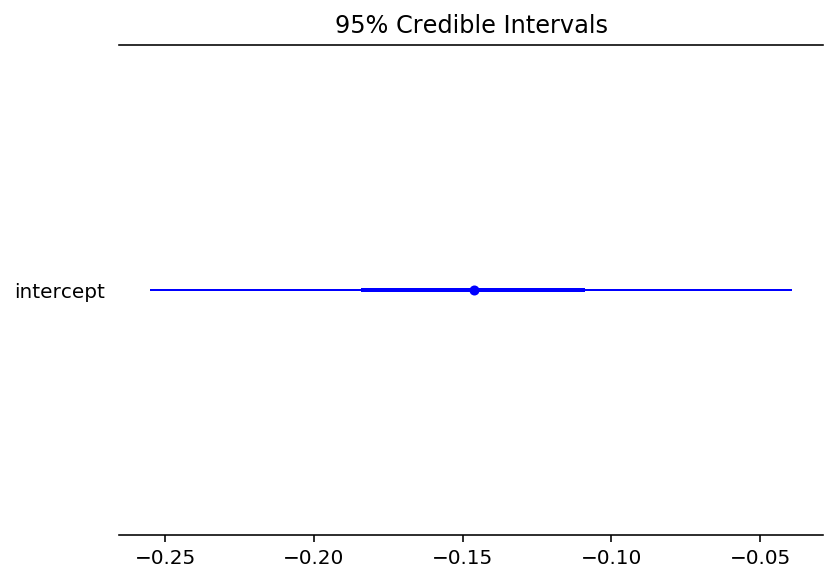

In [16]:
pymc.Matplot.summary_plot(intercept)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


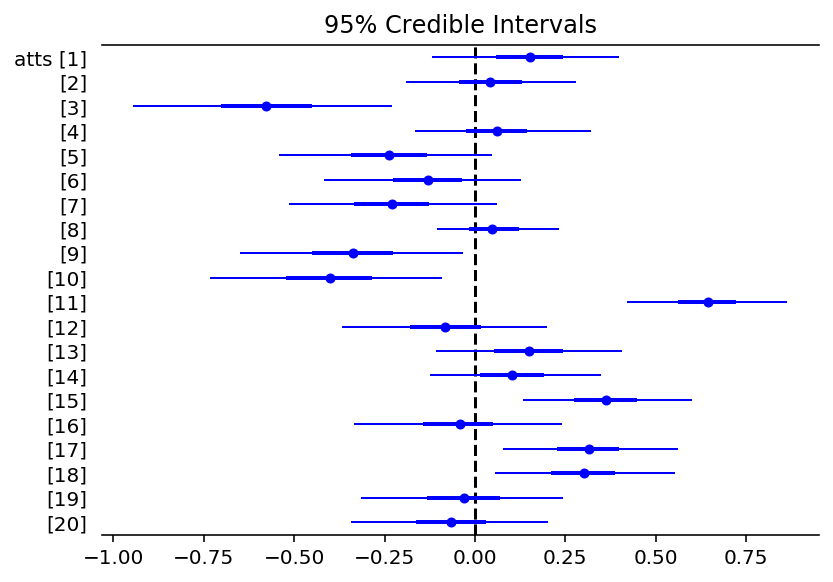

In [17]:
pymc.Matplot.summary_plot(atts)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


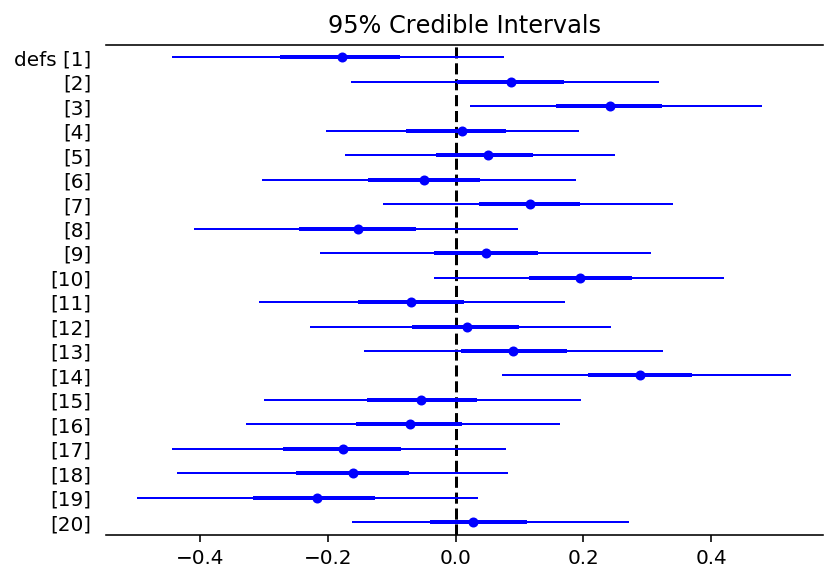

In [18]:
pymc.Matplot.summary_plot(defs)

O interceptação também parece bom e possui um IDH que não inclui zero, indicando que incluir um intercepto foi uma boa ideia:

Generating histogram of tau_att


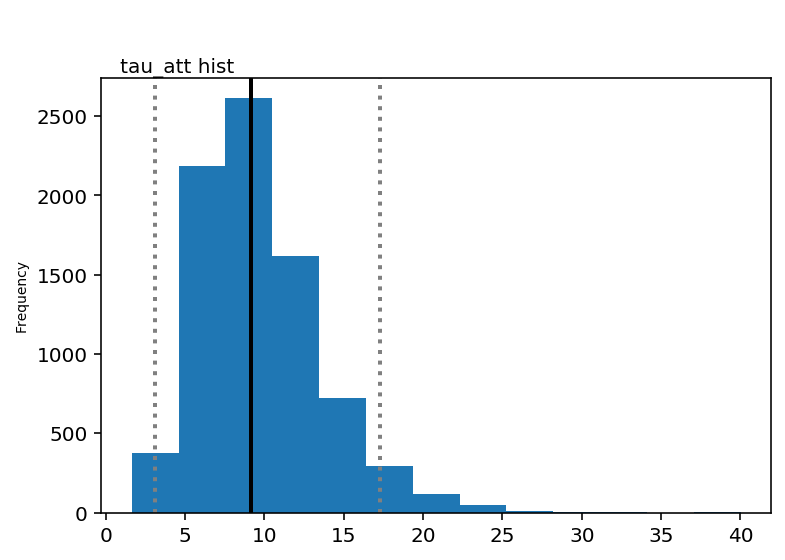

In [19]:
pymc.Matplot.histogram(tau_att)

In [20]:
tau_att.summary()


tau_att:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	9.691            3.888            0.086            [ 3.121 17.305]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	4.041            6.911           9.131          11.697        19.124
	


Generating histogram of tau_def


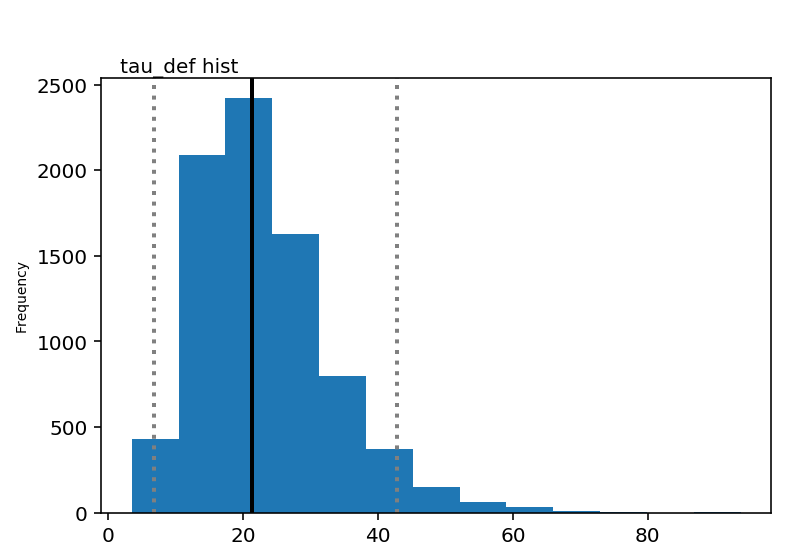

In [21]:
pymc.Matplot.histogram(tau_def)

In [22]:
tau_def.summary()


tau_def:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	23.113           9.983            0.285            [ 6.797 42.799]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	8.722            15.95           21.317         28.313        47.432
	


In [23]:
observed_season = DATA_DIR + 'resultado_brasileiro_serie_A_2019.csv'
df_observed = pd.read_csv(observed_season, sep=';')
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''

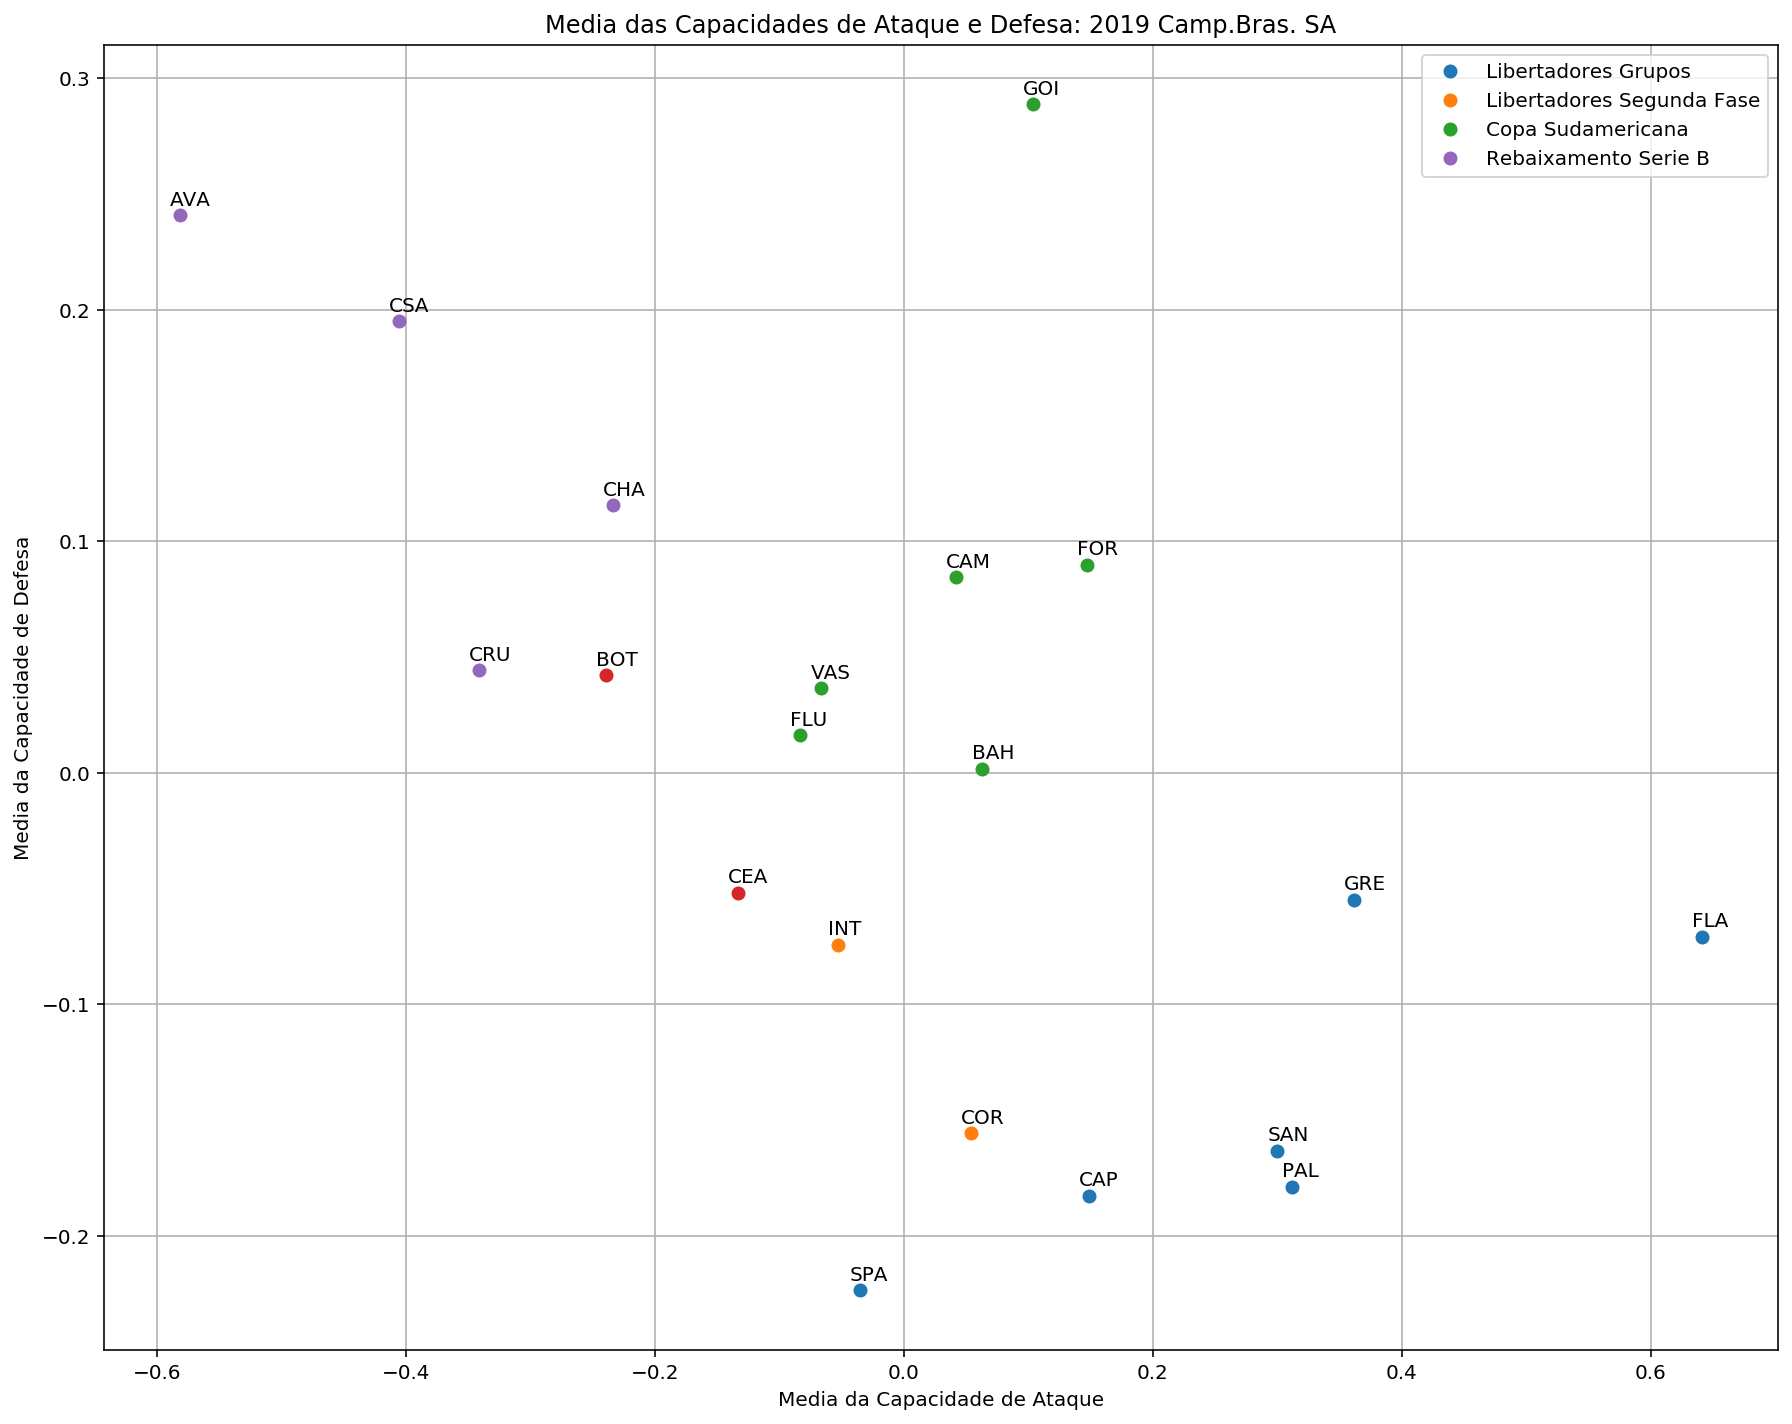

In [28]:
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']}, 
                      index=teams.team.values)
df_avg = pd.merge(df_avg, df_observed, left_index=True, right_on='time', how='left')

fig, ax = plt.subplots(figsize=(15,12))
for outcome in ['Libertadores Grupos', 'Libertadores Segunda Fase', 'Copa Sudamericana', '', 'Rebaixamento Serie B']:
    ax.plot(df_avg.avg_att[df_avg.QR == outcome], 
            df_avg.avg_def[df_avg.QR == outcome], 'o', label=outcome)
    
for label, x, y in zip(df_avg.time.values, df_avg.avg_att.values, df_avg.avg_def.values):
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
ax.set_title('Media das Capacidades de Ataque e Defesa: 2019 Camp.Bras. SA')
ax.set_xlabel('Media da Capacidade de Ataque')
ax.set_ylabel('Media da Capacidade de Defesa')
ax.legend()
ax.grid()

Assim como você esperaria, as melhores equipes estão no canto inferior direito do gráfico, indicando um efeito de ataque positivo e um efeito de defesa negativo.  
Curiosamente, o Manchester United (MNU) parece ter um ataque mais forte e uma defesa mais forte do que duas equipes que terminaram acima dele na tabela, Everton (EVE) e Tottenham (TOT).  
Mas aqui estamos apenas olhando para as medias posteriores, e devemos tirar proveito do fato de podermos quantificar nossa incerteza posterior em torno desses parâmetros.   
Vejamos os intervalos de maior densidade posterior para os parâmetros de ataque.

In [29]:
pd.DataFrame(atts.stats()['95% HPD interval']).T

,0,1
0,-0.114706,0.395483
1,-0.188717,0.276660
2,-0.942747,-0.230920
3,-0.162978,0.318556
4,-0.540486,0.044520
5,-0.414278,0.123559
6,-0.512559,0.057113
7,-0.103364,0.229315
8,-0.647775,-0.036583
9,-0.729383,-0.094817


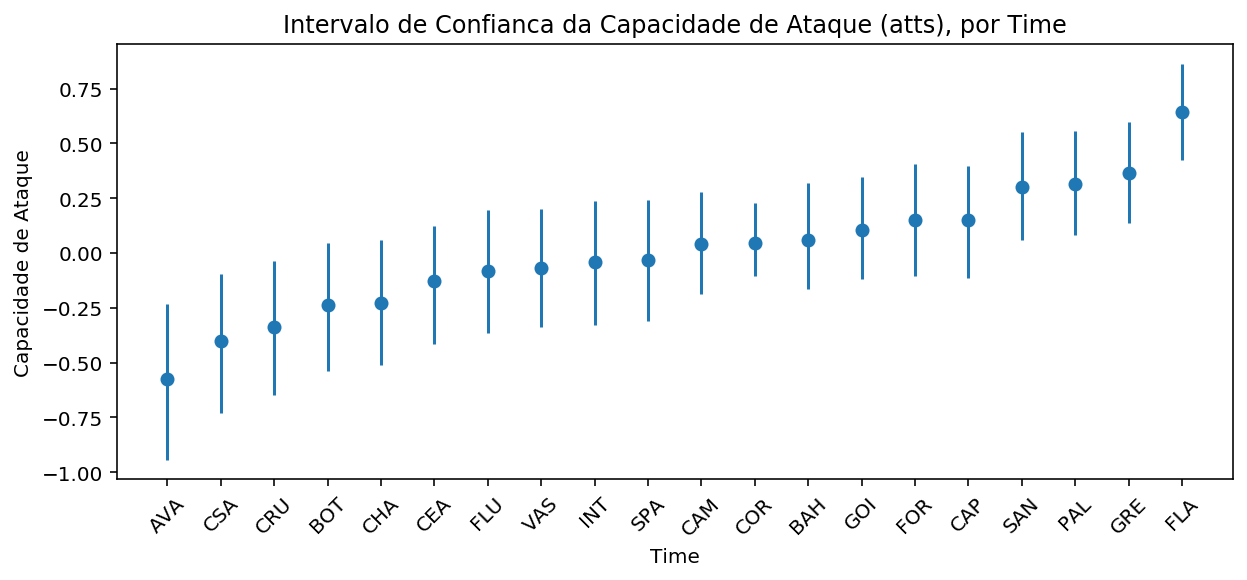

In [32]:
df_hpd = pd.DataFrame(atts.stats()['95% HPD interval']).T
df_hpd.columns=['hpd_low', 'hpd_high']
df_hpd.index=teams.team.values
df_median = pd.DataFrame(atts.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('Intervalo de Confianca da Capacidade de Ataque (atts), por Time')
axs.set_xlabel('Time')
axs.set_ylabel('Capacidade de Ataque')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Observe que os intervalos para MNU, EVE e TOT se sobrepõem significativamente. De fato, há um grande conjunto de equipes no meio com HPDs sobrepostos. No entanto, podemos estar bastante confiantes de que a força de ataque de Liverpool e Man City deixou o resto do grupo para trás, o que faz sentido, pois cada um deles marcou 30 gols a mais que o Chelsea, o time com o terceiro maior número de gols. De fato, podemos concluir que os ataques deles estavam ainda mais longe do resto do grupo, se não fosse por encolhimento. Para entender o que quero dizer, vamos simular algumas temporadas.

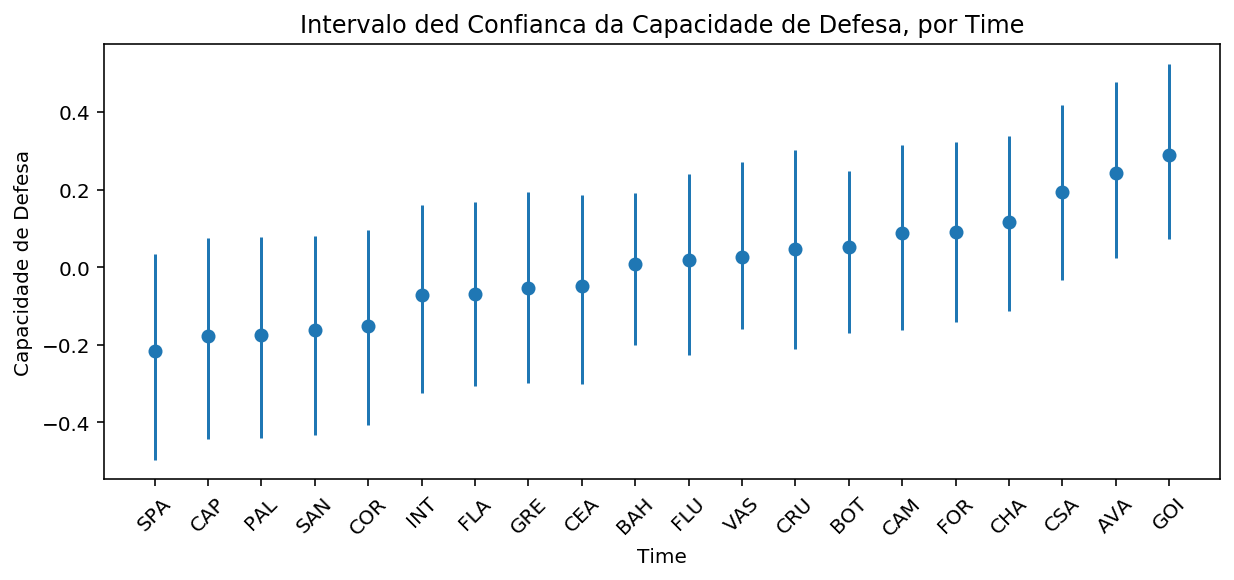

In [33]:
df_hpd = pd.DataFrame(defs.stats()['95% HPD interval']).T
df_hpd.columns=['hpd_low', 'hpd_high']
df_hpd.index=teams.team.values
df_median = pd.DataFrame(defs.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('Intervalo ded Confianca da Capacidade de Defesa, por Time')
axs.set_xlabel('Time')
axs.set_ylabel('Capacidade de Defesa')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Simulações
Podemos tirar empates das distribuições posteriores dos parâmetros e simular uma temporada ou muitas temporadas. Abaixo está o código de simulação, para que você possa ver como eu fiz.

In [36]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_values(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [37]:
simuls = simulate_seasons(1000)

Text(78.0, 278.855, 'Mediana: 77.0')

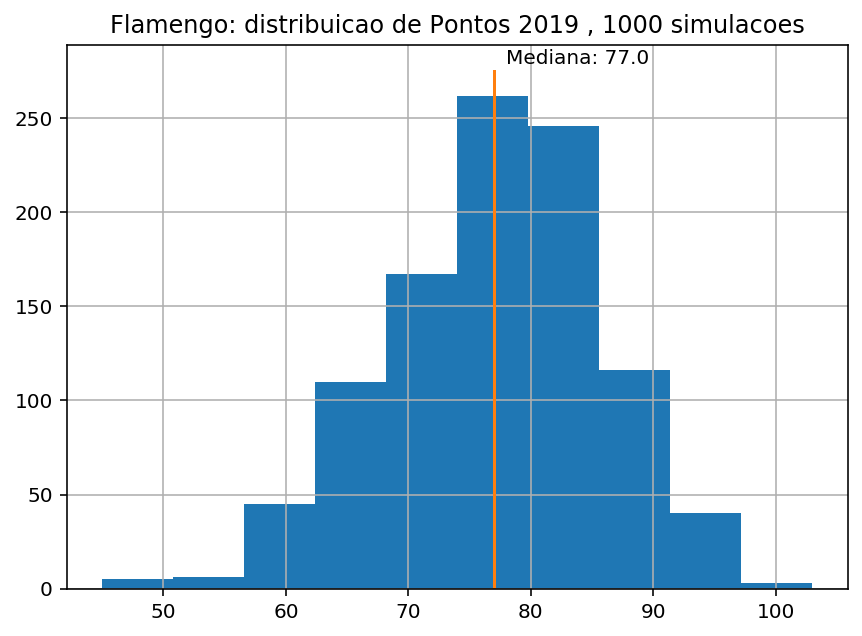

In [38]:
ax = simuls.points[simuls.team == 'FLA'].hist(figsize=(7,5))
median = simuls.points[simuls.team == 'FLA'].median()
ax.set_title('Flamengo: distribuicao de Pontos 2019 , 1000 simulacoes')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Mediana: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

Text(57.0, 281.06, 'Mediana: 56.0')

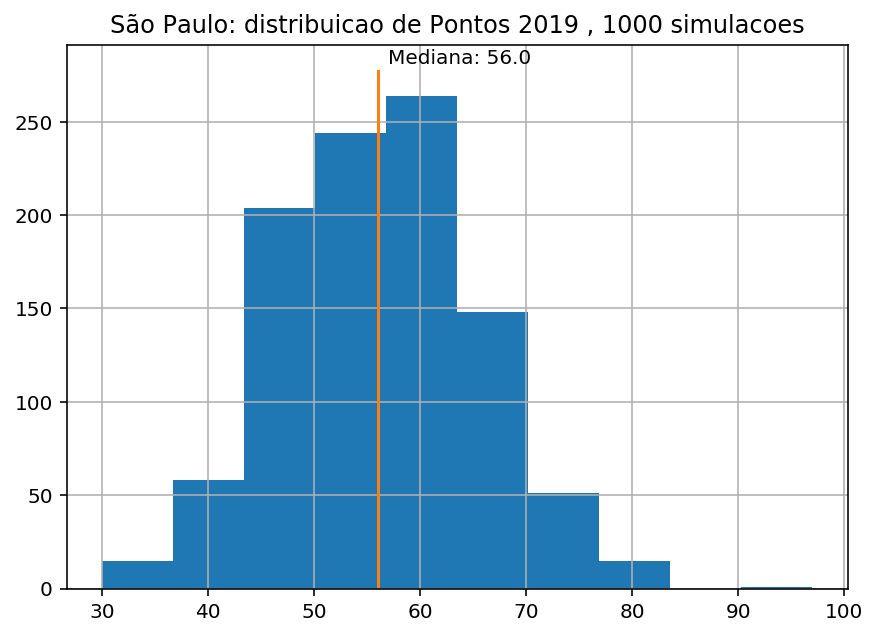

In [40]:
ax = simuls.points[simuls.team == 'SPA'].hist(figsize=(7,5))
median = simuls.points[simuls.team == 'SPA'].median()
ax.set_title('São Paulo: distribuicao de Pontos 2019 , 1000 simulacoes')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Mediana: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

Text(30.0, 267.83000000000004, 'Mediana: 29.0')

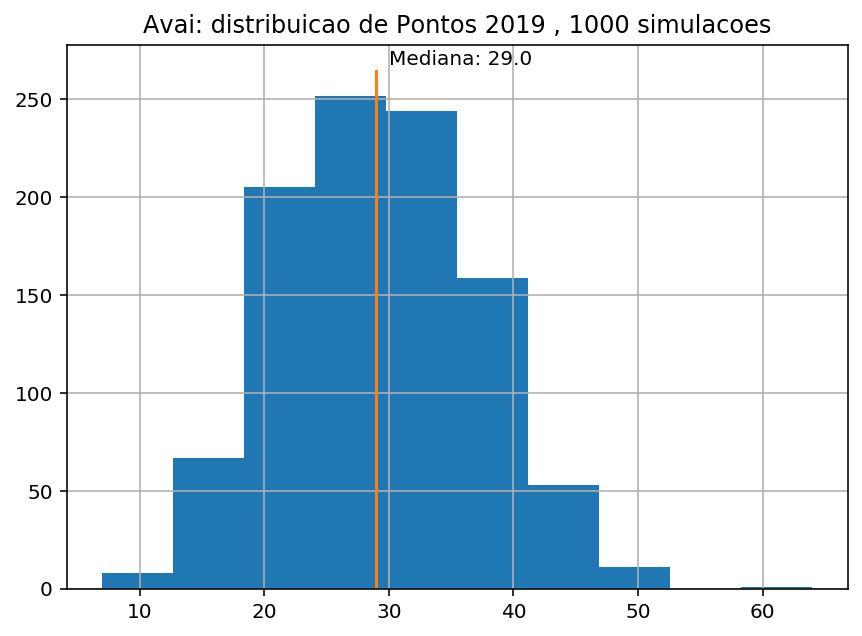

In [41]:
ax = simuls.points[simuls.team == 'AVA'].hist(figsize=(7,5))
median = simuls.points[simuls.team == 'AVA'].median()
ax.set_title('Avai: distribuicao de Pontos 2019 , 1000 simulacoes')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Mediana: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

In [43]:
so = simuls.sort_values(by='position')

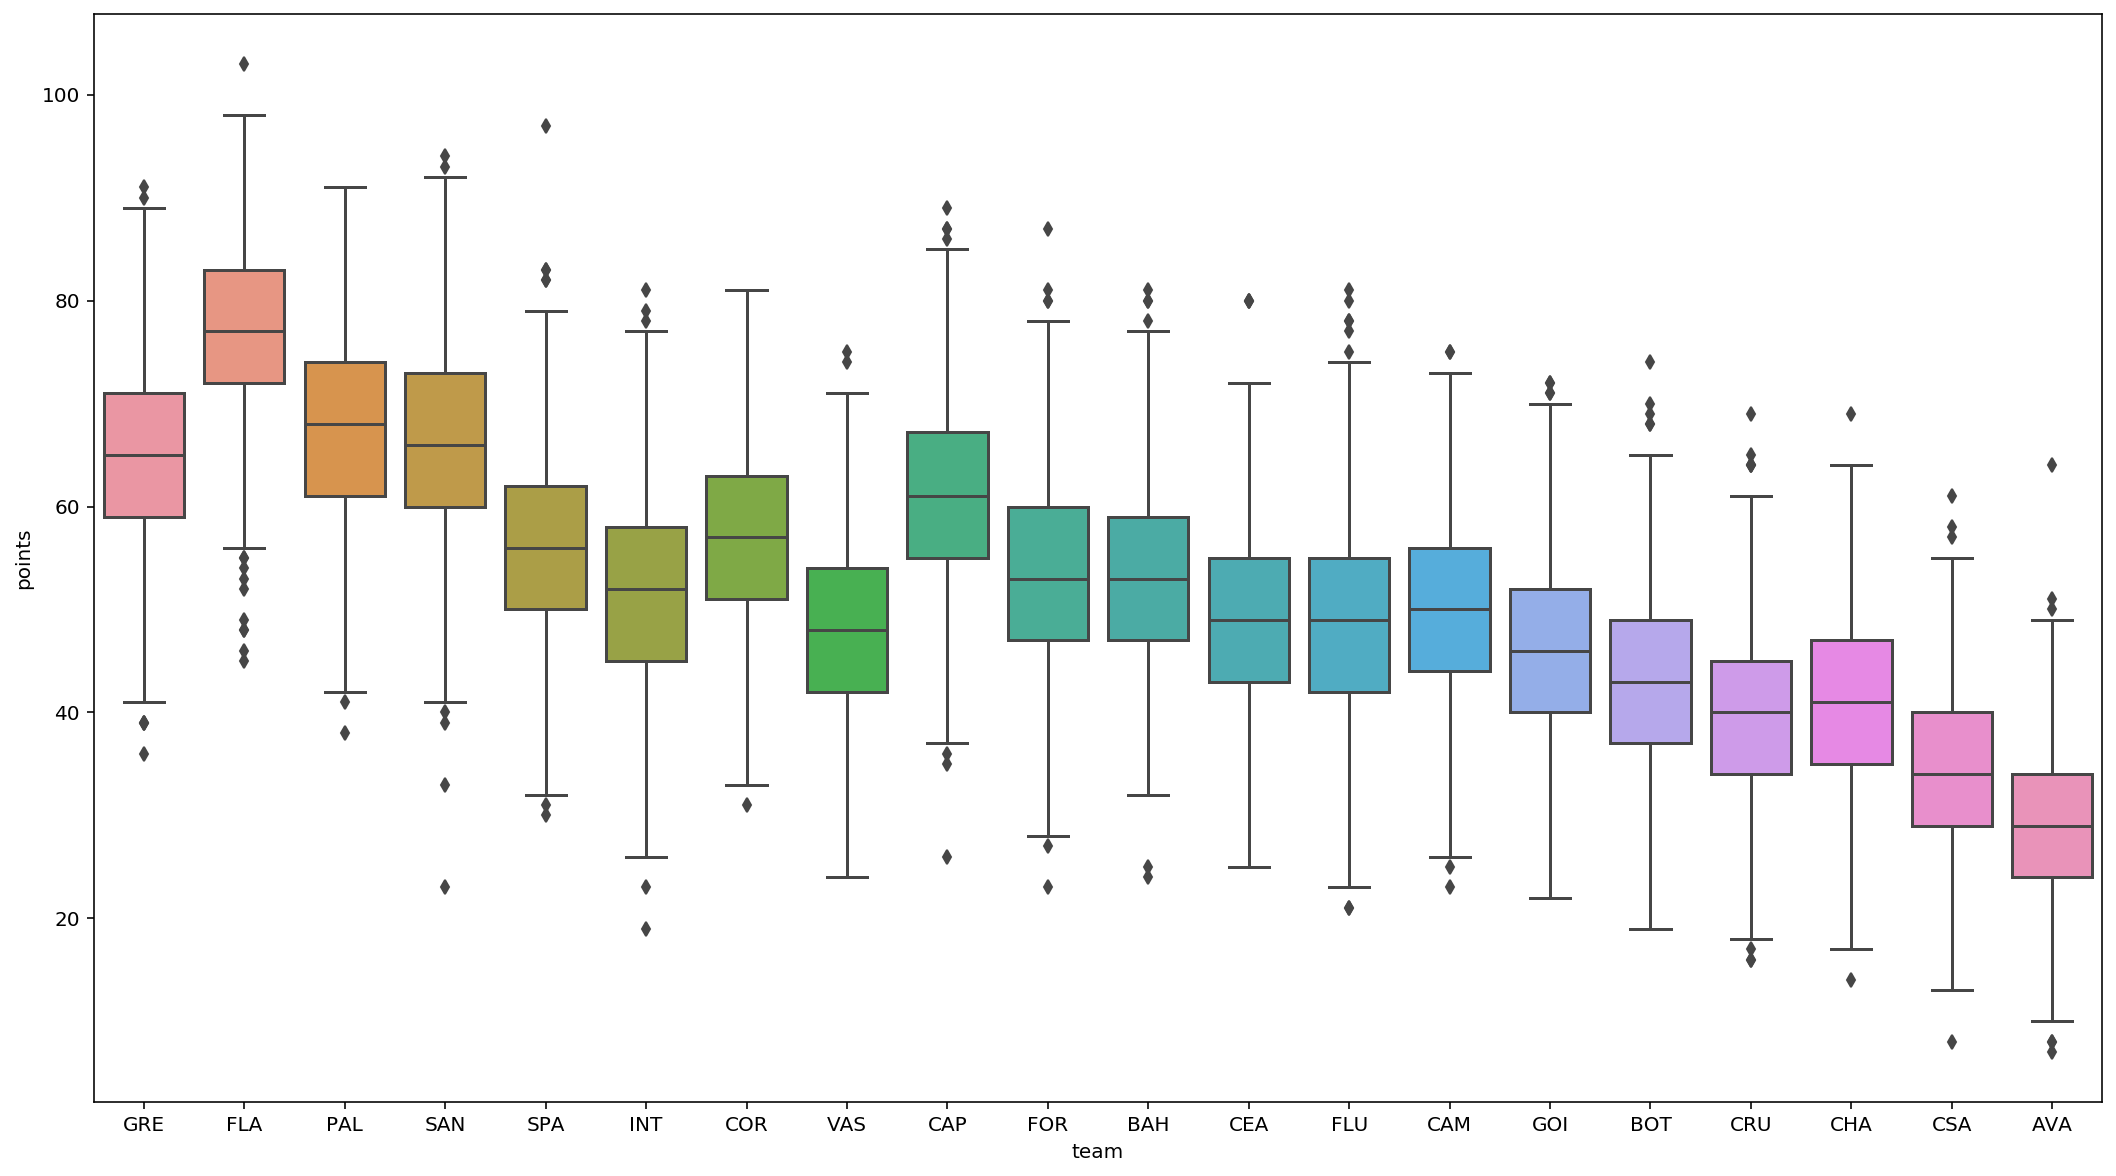

In [69]:
plt.figure(figsize=(18,10))
sns.boxplot(x="team", y="points", data=so)

In [45]:
dfo = df_avg.sort_values(by='Pts', ascending=False)

In [46]:
so_mean = so.groupby('team').mean()['points']
so_max = so.groupby('team').max()['points']
so_min = so.groupby('team').min()['points']
so_std = so.groupby('team').std()['points']
so_median = so.groupby('team').median()['points']

In [47]:
new_so = pd.concat([so_mean, so_median, so_max, so_min, so_std], axis=1)

In [48]:
new_so.columns = ['media','mediana','maximo','minimo','std']

In [49]:
dfo.columns = [u'avg_att', u'avg_def', u'Pos', u'team', u'team_name', u'Pld', u'W',
       u'D', u'L', u'GF', u'GA', u'GD', u'Pts', u'QR']

In [50]:
dfo = dfo.merge(new_so, left_on='team', right_on='team')

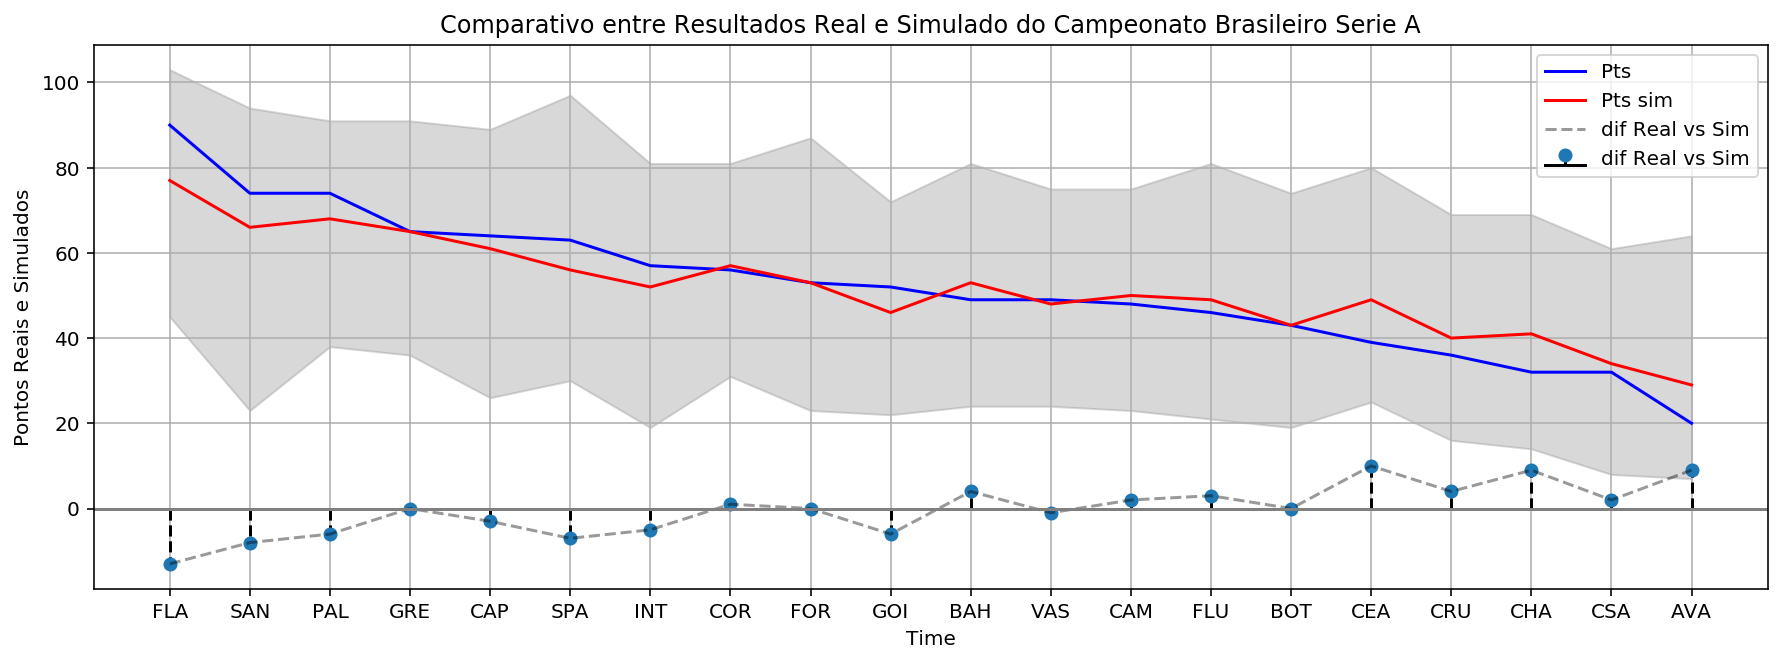

In [51]:
plt.figure(figsize=(15,5))
plt.plot(dfo.team, dfo.Pts, 'blue',label='Pts')
plt.plot(dfo.team,dfo.mediana, 'red', label='Pts sim')
plt.stem(dfo.team, dfo.mediana-dfo.Pts, 'k--',label='dif Real vs Sim', basefmt='k-')
plt.plot(dfo.team, dfo.mediana-dfo.Pts, 'k--',label='dif Real vs Sim', alpha=0.4)
plt.axhline(y=0, color='gray')
plt.fill_between(dfo.team,dfo.minimo,dfo.maximo, color='gray', alpha =0.3)
plt.title('Comparativo entre Resultados Real e Simulado do Campeonato Brasileiro Serie A')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pontos Reais e Simulados')
plt.grid()

In [52]:
import seaborn as sns

In [53]:
dff = dfo[['avg_att','avg_def', 'W','D', 'L', 'mediana', 'Pts']]
dff.columns = [u'Ataque', u'Defesa', u'Vitórias', u'Empates', u'Derrotas', u'Pts Med Sim', u'Pts Real']

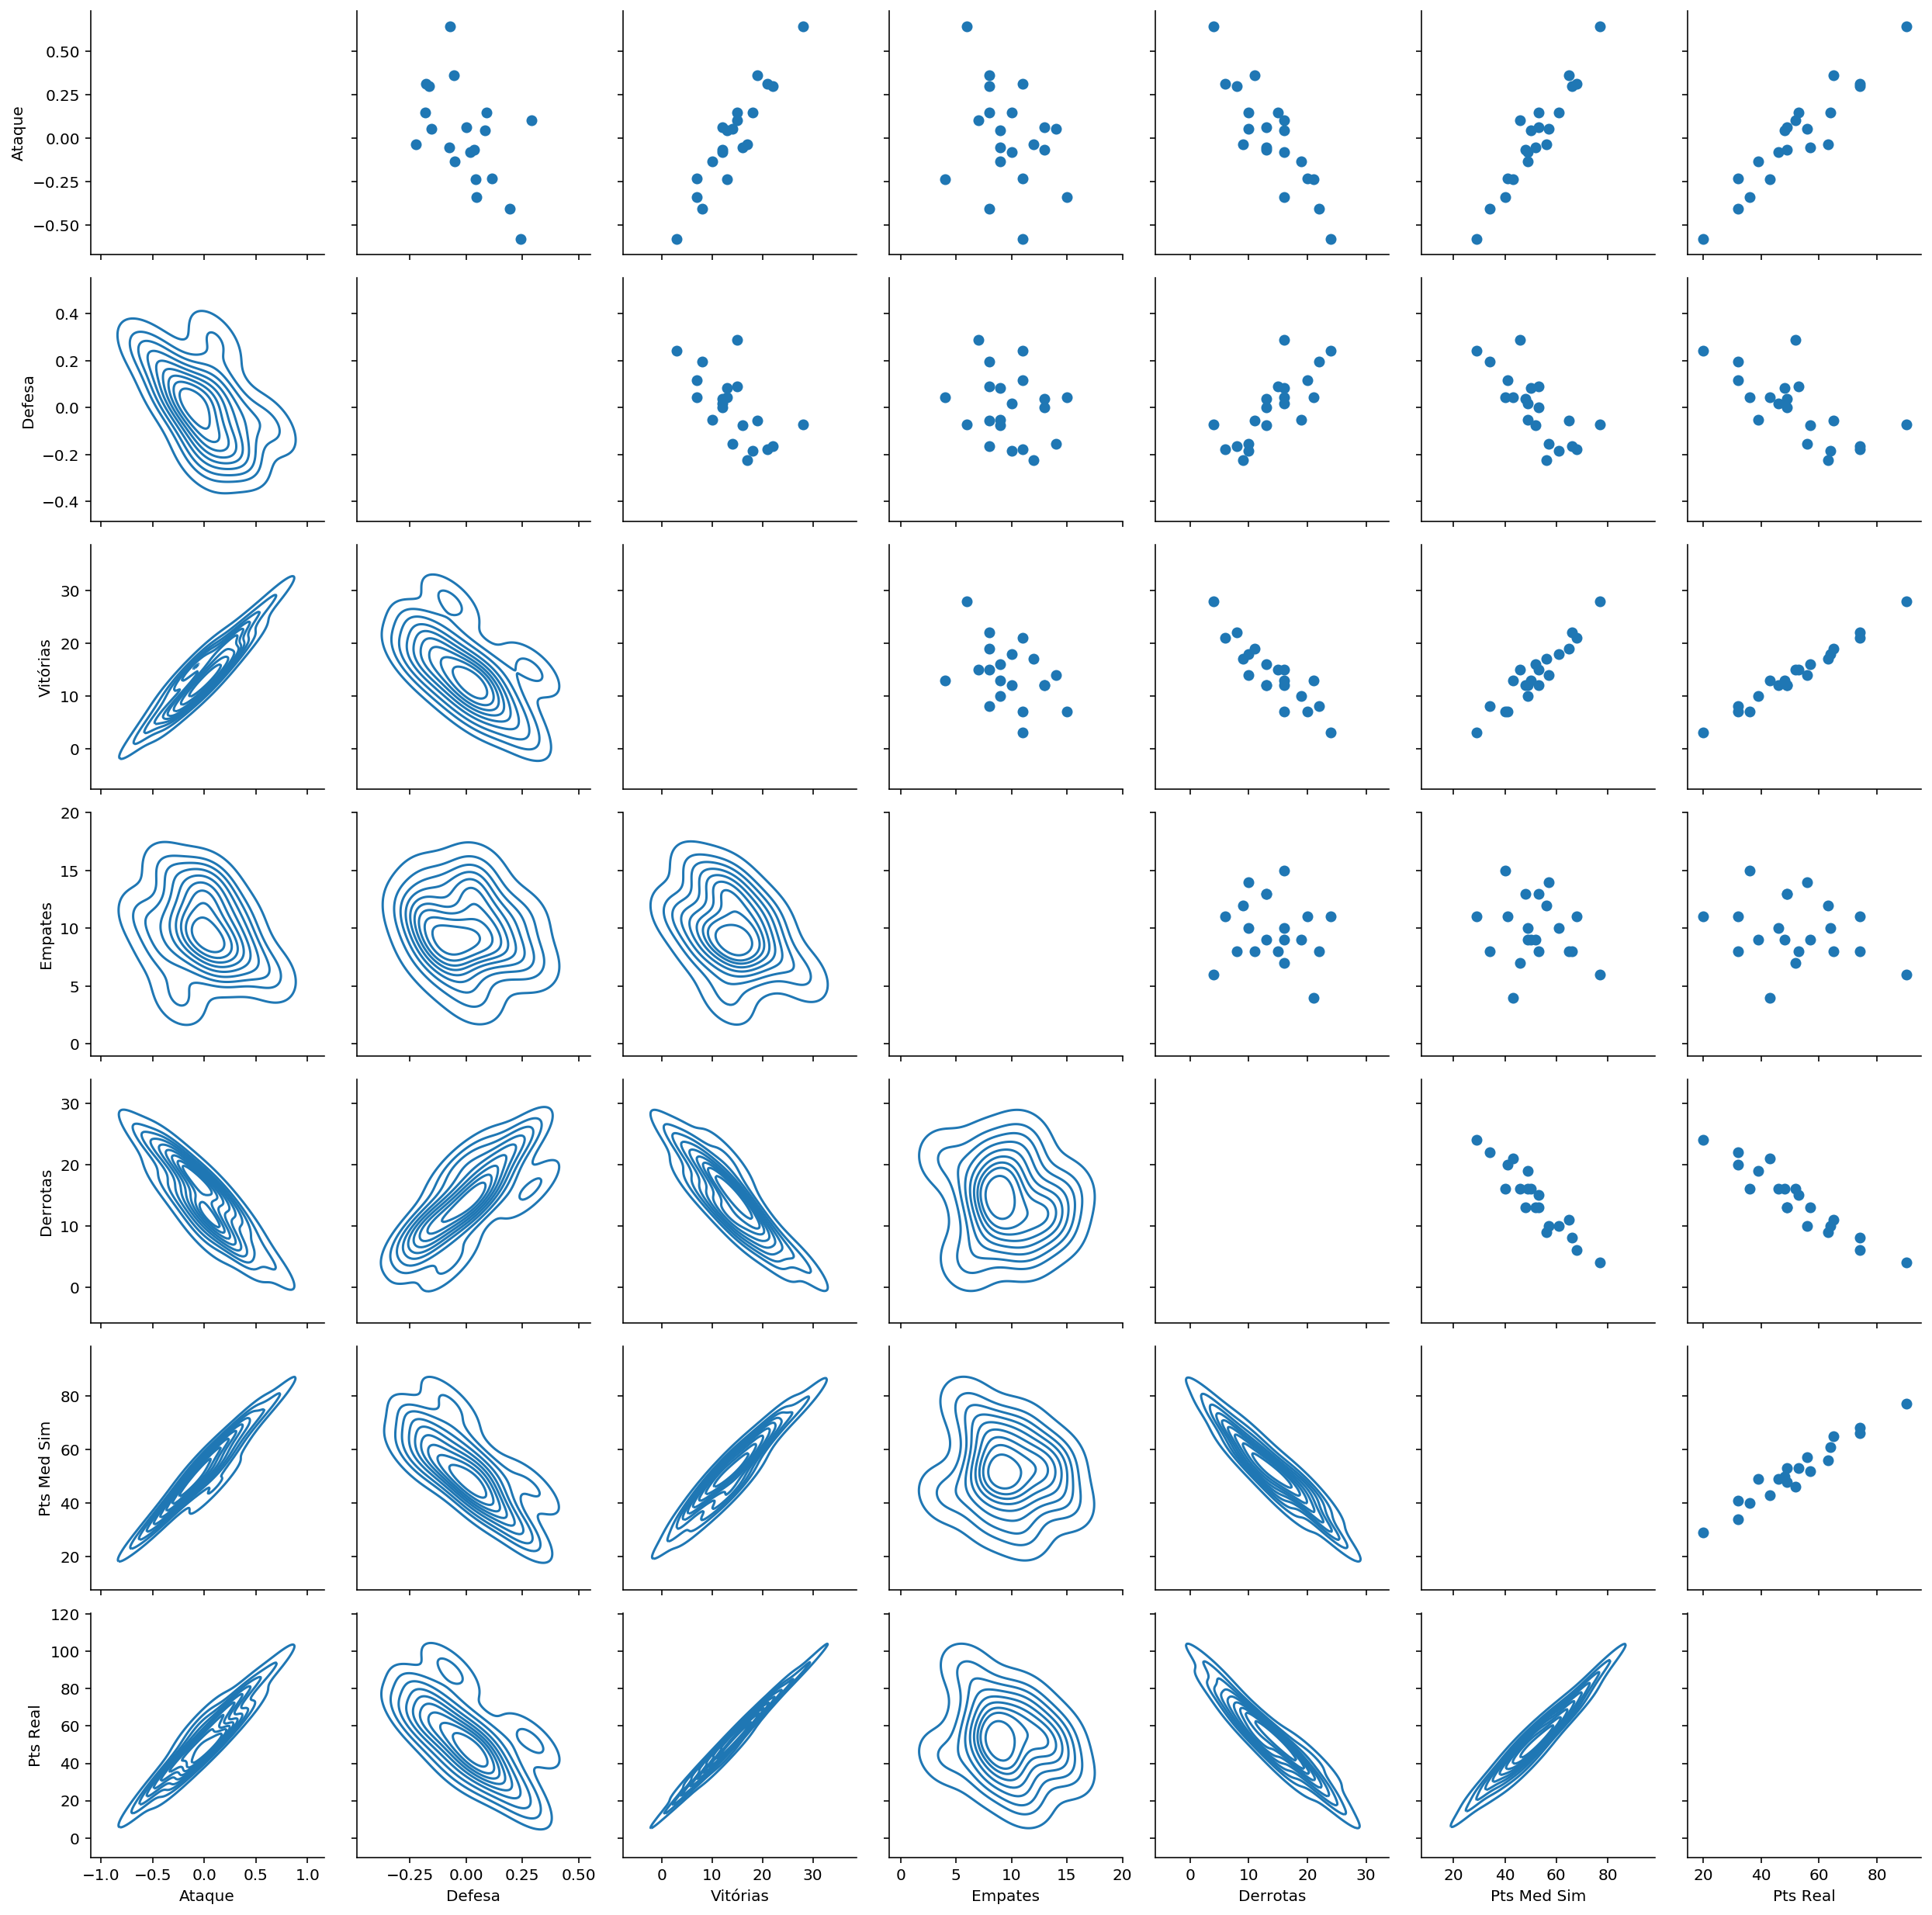

In [54]:
g = sns.PairGrid(dff)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(plt.hist);